In [78]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np
import sys
import astropy.units as u
from astropy.io import ascii, fits
from astropy.modeling.blackbody import blackbody_lambda
sys.path.insert(0, '../')
from libra import Spot, Star, IRTFTemplate

In [79]:
f = fits.open('../libra/data/trappist1/mage_2306-0502_090827.fits')

wavelength = f[0].data[0, :]* u.Angstrom
flux = f[0].data[1, :] * u.erg * u.s**-1 * u.cm**-2 * u.Angstrom**-1
flux = flux.to(u.W * u.m**-2 * u.um**-1)
flux[(flux < 0) | np.isnan(flux)] = 0

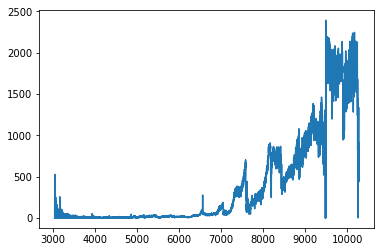

In [80]:
plt.plot(wavelength, flux)

In [161]:
from synphot import units, SourceSpectrum, Empirical1D, Observation

from synphot import SpectralElement

v = SourceSpectrum.from_vega()

bp_v = SpectralElement.from_filter('johnson_v')
bp_r = SpectralElement.from_filter('cousins_r')
bp_i = SpectralElement.from_filter('cousins_i')
bp_j = SpectralElement.from_file('/Users/bmmorris/git/libra/libra/data/filters/2MASS_2MASS.J.dat.txt')

sp = SourceSpectrum(Empirical1D, points=wavelength.to(u.Angstrom), lookup_table=flux)

force = 'taper'
obs_v = Observation(sp, bp_v, force=force)
obs_r = Observation(sp, bp_r, force=force)
obs_i = Observation(sp, bp_i, force=force)
obs_j = Observation(sp, bp_j, force=force)

DisjointError: Source spectrum and bandpass are disjoint.

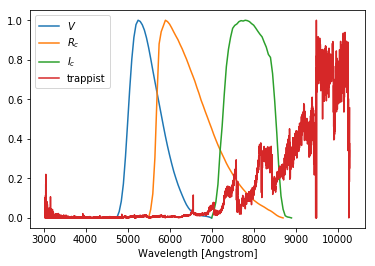

In [162]:
tmp = bp_v.model
plt.plot(tmp.points[0], tmp.lookup_table, label='$V$')
tmp = bp_r.model
plt.plot(tmp.points[0], tmp.lookup_table, label='$R_c$')
tmp = bp_i.model
plt.plot(tmp.points[0], tmp.lookup_table, label='$I_c$')
plt.plot(wavelength, flux/flux.max(), label='trappist')
plt.legend()
plt.xlabel('Wavelength [Angstrom]')
plt.savefig('optical.png', dpi=200)

In [163]:
from synphot import units, SourceSpectrum, Empirical1D, Observation

from synphot import SpectralElement

v = SourceSpectrum.from_vega()

sp = SourceSpectrum(Empirical1D, points=wavelength, lookup_table=flux)
trappist_1_v_minus_r = obs_v.effstim('vegamag', vegaspec=v) - obs_r.effstim('vegamag', vegaspec=v)
trappist_1_r_minus_i = obs_r.effstim('vegamag', vegaspec=v) - obs_i.effstim('vegamag', vegaspec=v)
trappist_1_r_minus_i = obs_r.effstim('vegamag', vegaspec=v) - obs_i.effstim('vegamag', vegaspec=v)
trappist_1_v_minus_i = obs_v.effstim('vegamag', vegaspec=v) - obs_i.effstim('vegamag', vegaspec=v)

print(trappist_1_v_minus_i)

4.732305260180496 VEGAMAG


In [164]:
V = 18.8 
R = 16.6
I = 14.0
V-R, R-I, V-I

(2.1999999999999993, 2.6000000000000014, 4.800000000000001)

In [147]:
from glob import glob

paths = glob('/Users/bmmorris/git/freckles/data/lte*BT-Settl.spec.fits')

from astropy.io import fits

phoenix_wavelengths = fits.getdata(paths[0])['Wavelength'] * u.um

temperatures = []
model_fluxes = []

for path in paths:
    hdu = fits.open(path)
    temperatures.append(hdu[1].header['PHXTEFF'])
    interp_flux = np.interp(phoenix_wavelengths, hdu[1].data['Wavelength'], hdu[1].data['Flux'])
    model_fluxes.append(interp_flux)
    
model_fluxes = np.vstack(model_fluxes)
temperatures = np.array(temperatures)

In [174]:
#temperature_grid = np.arange(2600, 7100, 100)
temperature_grid = temperatures[(temperatures >= 2000)]
colors = []
for temp in temperature_grid:
    spectrum = model_fluxes[np.argmin(np.abs(temperatures - temp)), :] * u.W * u.m**-2 * u.um**-1

    sp = SourceSpectrum(Empirical1D, points=phoenix_wavelengths, lookup_table=spectrum)

    force = 'taper'
    obs_v = Observation(sp, bp_v, force=force)
#     obs_r = Observation(sp, bp_r, force=force)
    obs_i = Observation(sp, bp_i, force=force)

    v_minus_i = obs_v.effstim('vegamag', vegaspec=v) - obs_i.effstim('vegamag', vegaspec=v)
    colors.append(v_minus_i.value)

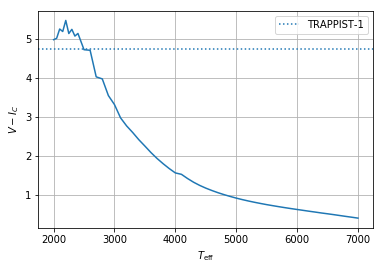

In [176]:
np.savetxt('temperature_to_v_minus_ic.txt', np.vstack([temperature_grid, colors]).T)

plt.plot(temperature_grid, [i for i in colors])
plt.ylabel('$V-I_C$')
plt.xlabel('$T_\mathrm{eff}$')
plt.axhline(trappist_1_v_minus_i.value, label='TRAPPIST-1', ls=':')
plt.grid()
plt.legend()
plt.savefig('teff_color.png', dpi=250)

In [236]:
area_grid = np.logspace(-4, 1, 100)
color_grid = np.zeros((len(colors), len(area_grid)))
for i, color in enumerate(colors):
    for j, area in enumerate(area_grid):
        color_grid[i, j] = (1 - area) * trappist_1_v_minus_i.value + area * color 

/Users/bmmorris/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:1376: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  'yscale=%s' % (xscale, yscale))


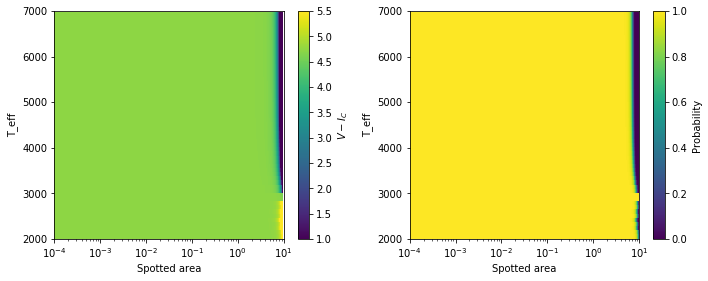

In [237]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
extent = [area_grid.min(), area_grid.max(), temperature_grid.min(), temperature_grid.max()]
img = ax[0].imshow(color_grid, aspect=1e-4, origin='lower', extent=extent, vmin=1.0, vmax=5.5)
ax[0].set_xscale('log')
plt.colorbar(img, ax=ax[0], label='$V - I_C$')
ax[0].set(xlabel='Spotted area', ylabel='T_eff')


extent = [area_grid.min(), area_grid.max(), temperature_grid.min(), temperature_grid.max()]
img = ax[1].imshow(np.exp(-0.5 * (color_grid - trappist_1_v_minus_i.value)**2), aspect=1e-4, origin='lower', extent=extent)
ax[1].set_xscale('log')
ax[1].set(xlabel='Spotted area', ylabel='T_eff')

plt.colorbar(img, ax = ax[1], label='Probability')
fig.tight_layout()
plt.savefig('color_prior.png', dpi=250)

In [228]:
probability_grid = np.exp(-0.5 * (color_grid - trappist_1_v_minus_i.value)**2)

np.savez('color_probability_grid.npz', probability_grid, area_grid, temperature_grid)

In [ ]:
# from astropy.utils.console import ProgressBar

# v_minus_r = np.zeros((len(spotted_areas), len(spot_temperatures)))

# with ProgressBar(len(spotted_areas) * len(spot_temperatures), ipython_widget=True) as bar:
#     for i, area in enumerate(spotted_areas): 
#         for j, temp in enumerate(spot_temperatures): 
#             hot_spot_flux = model_fluxes[np.argmin(np.abs(temperatures - temp)), :]
#             bs = binned_statistic(phoenix_wavelengths, hot_spot_flux, bins=wavelength_bins.value, statistic='mean')
#             binned_phoenix = bs.statistic
#             binned_phoenix[np.isnan(binned_phoenix)] = 0
#             binned_phoenix *= scale_factor.value
            
#             total_flux = binned_phoenix * area + (1 - area) * flux.value

#             sp = SourceSpectrum(Empirical1D, points=wavelength.to(u.Angstrom), lookup_table=total_flux * flux.unit)
#             force = 'taper'
#             obs_i = Observation(sp, bp_i, force=force)
#             obs_j = Observation(sp, bp_j, force=force)
            
#             grid_vegamag = obs_i.effstim('vegamag', vegaspec=v) - obs_j.effstim('vegamag', vegaspec=v)

#             i_minus_j[i, j] = grid_vegamag.value

In [240]:
samples = np.loadtxt('posteriors_bright_spot.txt')
kepler_contrasts, spot_temperatures = np.loadtxt('contrast_to_temperature.txt', unpack=True)
interpolate_contrast_to_temperature = lambda x: np.interp(x, kepler_contrasts, spot_temperatures)

temperature_samples = interpolate_contrast_to_temperature(samples[:, -2])
area_samples = np.sum(np.pi*samples[:, 2::3]**2, axis=1)


Text(0,0.5,'T_eff')

/Users/bmmorris/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:1376: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  'yscale=%s' % (xscale, yscale))


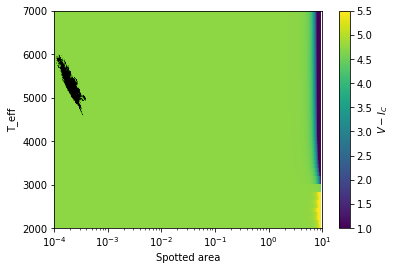

In [247]:
img = plt.imshow(color_grid, aspect=1e-4, origin='lower', extent=extent, vmin=1.0, vmax=5.5)
plt.plot(area_samples, temperature_samples, '.k', alpha=0.004, ms=2)

plt.xscale('log')
plt.colorbar(img, label='$V - I_C$')
plt.xlabel('Spotted area')
plt.ylabel('T_eff')

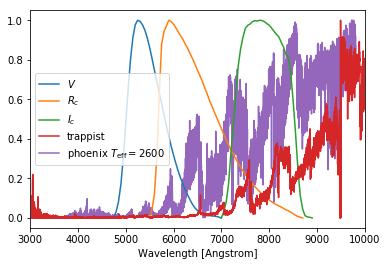

In [159]:
from scipy.ndimage import gaussian_filter1d
tmp = bp_v.model
plt.plot(tmp.points[0], tmp.lookup_table, label='$V$')
tmp = bp_r.model
plt.plot(tmp.points[0], tmp.lookup_table, label='$R_c$')
tmp = bp_i.model
plt.plot(tmp.points[0], tmp.lookup_table, label='$I_c$')
plt.plot(wavelength, flux/flux.max(), label='trappist')

# convolve_ratio = np.median(np.diff(wavelength)) / np.median(np.diff(phoenix_wavelengths))

spectrum = model_fluxes[np.argmin(np.abs(temperatures - 2600)), :]
# condition = (phoenix_wavelengths* u.um < 10000 * u.Angstrom) & (phoenix_wavelengths* u.um > 3000 * u.Angstrom)
# chunk_flux = gaussian_filter1d(spectrum[condition], convolve_ratio.value)
# chunk_wavelength = phoenix_wavelengths[condition] * 10000

from scipy.stats import binned_statistic

binsize = np.median(np.diff(wavelength.value))
bins = np.linspace(wavelength.min().value - binsize/2, wavelength.max().value + binsize/2, len(wavelength) + 1)
bs = binned_statistic(phoenix_wavelengths[condition] * 10000, spectrum[condition], bins=bins, statistic='mean')
phoenix_optical = bs.statistic
#plt.plot(wavelength.value + 1010, phoenix_optical/np.nanmax(phoenix_optical), zorder=-100, label='phoenix $T_\mathrm{eff} = 2600$')
plt.plot(wavelength.value, phoenix_optical/np.nanmax(phoenix_optical), zorder=-100, label='phoenix $T_\mathrm{eff} = 2600$')

plt.xlim([3000, 10000])
plt.legend()
plt.xlabel('Wavelength [Angstrom]')
plt.savefig('optical.png', dpi=200)